# Kernelized Linear Classification

## Initial imports + functions

Basic libraries + custom functions (ffunctions.py) + data loading

In [29]:
#Initial Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#So plots appear inline

# 1. Import our custom functions
from ffunctions import (
    load_data,
    train_test_split,
    standard_scaler_fit,
    standard_scaler_transform,
    detect_outliers_zscore,
    remove_outliers,
    check_high_correlation,
    k_fold_cross_validation,
    pca_transform,
    perceptron_classifier_func,
    perceptron_train_eta,
    perceptron_classifier_func_eta,
    pegasos_train,
    pegasos_predict,
    pegasos_classifier_func,
    logistic_regression_train,
    logistic_regression_predict,
    logistic_regression_classifier_func,
)

In [30]:
# 2. Load the dataset
csv_path = "/Users/michelecoaro/Documents/GitHub/KLC/klc_project/dataset.csv"
df = load_data(csv_path)
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,1.205492,5.823226,98.837539,-1.075852,0.999205,0.911543,3.623558,-1.720267,-0.346191,-54.708330,-1
1,1.692571,-0.887019,100.901276,-0.595548,0.177550,-0.915495,4.320264,0.907834,3.126815,-56.397484,-1
2,4.289320,1.416843,100.784735,-2.897154,-0.066972,-0.786173,2.093003,1.336237,2.183829,-56.197728,1
3,0.542420,-1.010095,100.015580,-3.070705,0.088324,-0.242669,0.767942,-0.284683,-2.104145,-55.794045,1
4,2.431765,-1.224177,100.709237,-0.102892,0.699031,-0.656315,-0.911784,-1.355873,1.537825,-55.917863,-1


# Exploratory Data Analysis

In [31]:
# Let's identify which columns are features vs. the target
# (This is based on your dataset structure)
features = [f"x{i}" for i in range(1, 11)]
target = "y"


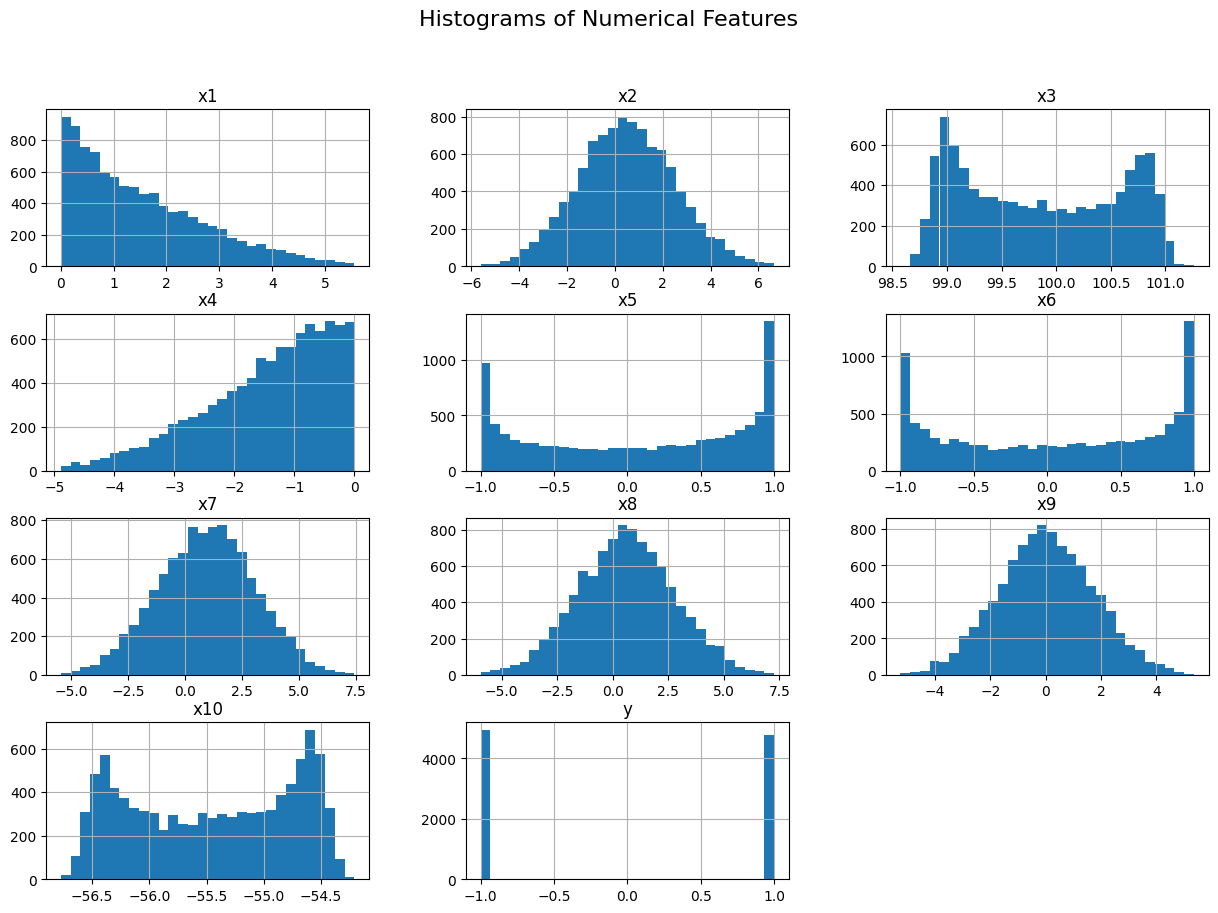

In [32]:
# 4. Histograms for Numerical Features
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()


In [33]:
# 3. Train-Test Split (to avoid leakage)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)


Train set shape: (7788, 11)
Test set shape: (1947, 11)


In [34]:
# 4. Check for outliers in the training set
outlier_indices = detect_outliers_zscore(train_df, features, z_thresh=3.0)
print(f"Number of outliers detected in training set: {len(outlier_indices)}")


Number of outliers detected in training set: 78


In [35]:
# Optionally remove outliers if it makes sense for your project
train_df_no_outliers = remove_outliers(train_df, outlier_indices)
print("Train set (no outliers) shape:", train_df_no_outliers.shape)

Train set (no outliers) shape: (7710, 11)


In [36]:
#5. Scaling
means, stds = standard_scaler_fit(train_df_no_outliers, features)
train_scaled = standard_scaler_transform(train_df_no_outliers, features, means, stds)
test_scaled = standard_scaler_transform(test_df, features, means, stds)


## Correlation Matrix

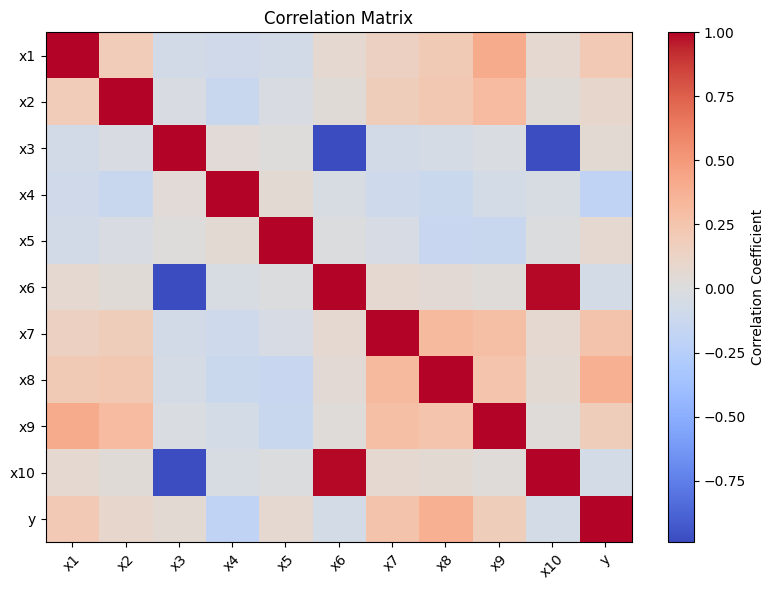

In [37]:
# 5. Correlation Matrix (for numerical columns)
corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.title('Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.tight_layout()
plt.show()


## Multicollinearity

In [38]:
# 6. Check for highly correlated features (multicollinearity)
high_corr_pairs = check_high_correlation(train_df_no_outliers, features, corr_threshold=0.95)
if high_corr_pairs:
    print("High correlation pairs detected (above threshold):")
    for pair in high_corr_pairs:
        print(f"  {pair[0]} and {pair[1]} with correlation = {pair[2]:.3f}")
else:
    print("No pairs of features exceed the correlation threshold.")

High correlation pairs detected (above threshold):
  x3 and x6 with correlation = 0.990
  x3 and x10 with correlation = 0.980
  x6 and x10 with correlation = 0.990


In [39]:
for col in ["x3", "x6", "x10"]:
    corr = train_df_no_outliers[col].corr(train_df_no_outliers["y"])
    print(col, corr)

x3 0.058816122258262944
x6 -0.06039355137913755
x10 -0.05863942944301634


# Algorithms Implementation

## Cross-validation

In [40]:
############################################
# 6. CROSS-VALIDATION EXPERIMENTS
############################################

# Our correlated columns of interest
corr_cols = ["x3", "x6", "x10"]

# A. Keep all features
feat_all = features

# B. Keep only x6
feat_keep_x6 = [f for f in features if f not in ["x3","x10"]]

# C. Keep only x10
feat_keep_x10 = [f for f in features if f not in ["x3","x6"]]

# D. Keep only x3
feat_keep_x3 = [f for f in features if f not in ["x6","x10"]]

# E. PCA on (x3, x6, x10) -> 1 or 2 components, let's do 1 for demonstration
train_scaled_pca, pca_vecs, pca_vals = pca_transform(train_scaled, corr_cols, n_components=1)
pca_features_1 = [col for col in train_scaled_pca.columns if col.startswith("PCA_")]
# plus the rest of the original features that were not x3,x6,x10
other_features = [f for f in features if f not in corr_cols]
feat_pca_1 = other_features + pca_features_1

# We'll do the same for 2 components just to illustrate
train_scaled_pca2, pca_vecs2, pca_vals2 = pca_transform(train_scaled, corr_cols, n_components=2)
pca_features_2 = [col for col in train_scaled_pca2.columns if col.startswith("PCA_")]
feat_pca_2 = other_features + pca_features_2

In [41]:
def cross_val_subset(df_scaled, subset_features, target_col, k=5):
    # We'll isolate only needed columns (subset_features + target_col)
    df_needed = df_scaled[subset_features + [target_col]]
    accuracy = k_fold_cross_validation(
        df_needed, 
        features=subset_features, 
        target=target_col, 
        k=k, 
        random_state=42, 
        classifier_func=None  # Using dummy classifier
    )
    return accuracy

In [42]:
acc_all = cross_val_subset(train_scaled, feat_all, target)
acc_x6 = cross_val_subset(train_scaled, feat_keep_x6, target)
acc_x10 = cross_val_subset(train_scaled, feat_keep_x10, target)
acc_x3 = cross_val_subset(train_scaled, feat_keep_x3, target)
acc_pca1 = cross_val_subset(train_scaled_pca, feat_pca_1, target)
acc_pca2 = cross_val_subset(train_scaled_pca2, feat_pca_2, target)


#### Dummy Cross Validation (discard)

In [43]:
print("\nCross-Validation Accuracy (Dummy Classifier):")
print(f"  All features:      {acc_all:.3f}")
print(f"  Keep only x6:      {acc_x6:.3f}")
print(f"  Keep only x10:     {acc_x10:.3f}")
print(f"  Keep only x3:      {acc_x3:.3f}")
print(f"  PCA(1) on x3,x6,x10: {acc_pca1:.3f}")
print(f"  PCA(2) on x3,x6,x10: {acc_pca2:.3f}")


Cross-Validation Accuracy (Dummy Classifier):
  All features:      0.511
  Keep only x6:      0.511
  Keep only x10:     0.511
  Keep only x3:      0.511
  PCA(1) on x3,x6,x10: 0.511
  PCA(2) on x3,x6,x10: 0.511


## Perceptron

### Actutal CV comparison

In [44]:
accuracy_perc_all = k_fold_cross_validation(
    train_scaled, 
    features=features, 
    target='y', 
    k=5, 
    random_state=42,
    classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
        tr_fold, vl_fold, f, t, epochs=5
    )
)

accuracy_perc_x6 = k_fold_cross_validation(
    train_scaled, 
    features=feat_keep_x6, 
    target='y', 
    k=5, 
    classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
        tr_fold, vl_fold, f, t, epochs=5
    )
)

accuracy_perc_x3 = k_fold_cross_validation(
    train_scaled, 
    features=feat_keep_x3, 
    target='y', 
    k=5, 
    classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
        tr_fold, vl_fold, f, t, epochs=5
    )
)

accuracy_perc_x10 = k_fold_cross_validation(
    train_scaled, 
    features=feat_keep_x10, 
    target='y', 
    k=5, 
    classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
        tr_fold, vl_fold, f, t, epochs=5
    )
)

accuracy_perc_pca1 = k_fold_cross_validation(
    train_scaled_pca, 
    features=feat_pca_1, 
    target='y', 
    k=5, 
    classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
        tr_fold, vl_fold, f, t, epochs=5
    )
)

accuracy_perc_pca2 = k_fold_cross_validation(
    train_scaled_pca2, 
    features=feat_pca_2, 
    target='y', 
    k=5, 
    classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
        tr_fold, vl_fold, f, t, epochs=5
    )
)

print(f"Perceptron (all features) 5-fold CV accuracy: {accuracy_perc_all:.3f}")
print(f"Perceptron (only x6 subset) 5-fold CV accuracy: {accuracy_perc_x6:.3f}")
print(f"Perceptron (only x3 subset) 5-fold CV accuracy: {accuracy_perc_x3:.3f}")
print(f"Perceptron (only x10 subset) 5-fold CV accuracy: {accuracy_perc_x10:.3f}")
print(f"Perceptron (PCA 1 component) 5-fold CV accuracy: {accuracy_perc_pca1:.3f}")
print(f"Perceptron (PCA 2 components) 5-fold CV accuracy: {accuracy_perc_pca2:.3f}")


Perceptron (all features) 5-fold CV accuracy: 0.600
Perceptron (only x6 subset) 5-fold CV accuracy: 0.616
Perceptron (only x3 subset) 5-fold CV accuracy: 0.623
Perceptron (only x10 subset) 5-fold CV accuracy: 0.618
Perceptron (PCA 1 component) 5-fold CV accuracy: 0.598
Perceptron (PCA 2 components) 5-fold CV accuracy: 0.610


### Hyperparameter Tuning

In [45]:
# Hyperparameter tuning for Perceptron
# Define hyperparameter search space
epochs_list = [5, 10, 20, 50]
learning_rates = [0.01, 0.1, 1.0]

# Dictionary to store results
tuning_results = {}

# Perform grid search over epochs and eta
for epochs in epochs_list:
    for eta in learning_rates:
        print(f"Testing epochs={epochs}, eta={eta}...")
        accuracy = k_fold_cross_validation(
            train_scaled,
            features=features,  # Use all features for tuning
            target='y',
            k=5,
            random_state=42,
            classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func_eta(
                tr_fold, vl_fold, f, t, epochs=epochs, eta=eta
            )
        )
        tuning_results[(epochs, eta)] = accuracy
        print(f"Accuracy: {accuracy:.3f}")

# Find the best hyperparameter combination
best_params = max(tuning_results, key=tuning_results.get)
best_accuracy = tuning_results[best_params]

print("\nBest Hyperparameters:")
print(f"  Epochs: {best_params[0]}")
print(f"  Learning Rate: {best_params[1]}")
print(f"  Accuracy: {best_accuracy:.3f}")


Testing epochs=5, eta=0.01...
Accuracy: 0.600
Testing epochs=5, eta=0.1...
Accuracy: 0.600
Testing epochs=5, eta=1.0...
Accuracy: 0.600
Testing epochs=10, eta=0.01...
Accuracy: 0.701
Testing epochs=10, eta=0.1...
Accuracy: 0.701
Testing epochs=10, eta=1.0...
Accuracy: 0.701
Testing epochs=20, eta=0.01...
Accuracy: 0.639
Testing epochs=20, eta=0.1...
Accuracy: 0.639
Testing epochs=20, eta=1.0...
Accuracy: 0.639
Testing epochs=50, eta=0.01...
Accuracy: 0.646
Testing epochs=50, eta=0.1...
Accuracy: 0.646
Testing epochs=50, eta=1.0...
Accuracy: 0.646

Best Hyperparameters:
  Epochs: 10
  Learning Rate: 0.01
  Accuracy: 0.701


In [46]:
# Extract best hyperparameters from tuning
best_epochs, best_eta = best_params

# Compare default and tuned Perceptron across feature subsets
subsets = {
    "Features": features,
    "Only x6": feat_keep_x6,
    "Only x3": feat_keep_x3,
    "Only x10": feat_keep_x10
}

comparison_results = {}

for subset_name, subset_features in subsets.items():
    print(f"\nEvaluating subset: {subset_name}")
    
    # Default Perceptron
    accuracy_default = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func(
            tr_fold, vl_fold, f, t, epochs=5  # Default epochs
        )
    )
    
    # Tuned Perceptron
    accuracy_tuned = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: perceptron_classifier_func_eta(
            tr_fold, vl_fold, f, t, epochs=best_epochs, eta=best_eta
        )
    )
    
    comparison_results[subset_name] = {
        "Default Perceptron": accuracy_default,
        "Tuned Perceptron": accuracy_tuned,
    }
    
    print(f"  Default Perceptron Accuracy: {accuracy_default:.3f}")
    print(f"  Tuned Perceptron Accuracy: {accuracy_tuned:.3f}")



Evaluating subset: Features
  Default Perceptron Accuracy: 0.600
  Tuned Perceptron Accuracy: 0.701

Evaluating subset: Only x6
  Default Perceptron Accuracy: 0.616
  Tuned Perceptron Accuracy: 0.666

Evaluating subset: Only x3
  Default Perceptron Accuracy: 0.623
  Tuned Perceptron Accuracy: 0.672

Evaluating subset: Only x10
  Default Perceptron Accuracy: 0.618
  Tuned Perceptron Accuracy: 0.671


### Default vs Hyperparameter

In [47]:
# Create a DataFrame to summarize results
comparison_df = pd.DataFrame.from_dict(comparison_results, orient='index')
comparison_df.columns = ["Default Perceptron Accuracy", "Tuned Perceptron Accuracy"]

# Display the comparison table
print("\nComparison of Default vs. Tuned Perceptron:")
display(comparison_df)

# Highlight differences
improvement_df = comparison_df["Tuned Perceptron Accuracy"] - comparison_df["Default Perceptron Accuracy"]
print("\nAccuracy Improvement (Tuned - Default):")
display(improvement_df)


Comparison of Default vs. Tuned Perceptron:


,Default Perceptron Accuracy,Tuned Perceptron Accuracy
Features,0.599741,0.700649
Only x6,0.616083,0.666407
Only x3,0.622957,0.671984
Only x10,0.617639,0.670817



Accuracy Improvement (Tuned - Default):


Features    0.100908
Only x6     0.050324
Only x3     0.049027
Only x10    0.053178
dtype: float64

## Pegasos SVM

### Comparison of different subsets

In [48]:
#PEGASOS SVM
# Define parameters for Pegasos
lambda_param = 0.01  # Regularization parameter
epochs = 10  # Number of epochs

# Compare Pegasos SVM across feature subsets
pegasos_results = {}

for subset_name, subset_features in subsets.items():
    print(f"\nEvaluating Pegasos SVM on subset: {subset_name}")
    
    accuracy_pegasos = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: pegasos_classifier_func(
            tr_fold, vl_fold, f, t, lambda_param=lambda_param, epochs=epochs
        )
    )
    
    pegasos_results[subset_name] = accuracy_pegasos
    print(f"  Pegasos SVM Accuracy: {accuracy_pegasos:.3f}")



Evaluating Pegasos SVM on subset: Features
  Pegasos SVM Accuracy: 0.730

Evaluating Pegasos SVM on subset: Only x6
  Pegasos SVM Accuracy: 0.732

Evaluating Pegasos SVM on subset: Only x3
  Pegasos SVM Accuracy: 0.731

Evaluating Pegasos SVM on subset: Only x10
  Pegasos SVM Accuracy: 0.730


In [49]:
# Create a DataFrame to compare results
comparison_pegasos = pd.DataFrame({
    "Perceptron (Default)": [comparison_results[name]["Default Perceptron"] for name in subsets.keys()],
    "Perceptron (Tuned)": [comparison_results[name]["Tuned Perceptron"] for name in subsets.keys()],
    "Pegasos SVM": [pegasos_results[name] for name in subsets.keys()]
}, index=list(subsets.keys()))  # Pass the index directly here

# Display the comparison
print("\nComparison of Perceptron vs. Pegasos SVM:")
display(comparison_pegasos)

# Highlight the best performance for each subset
print("\nBest Performances by Model for Each Subset:")
best_models = comparison_pegasos.idxmax(axis=1)
display(best_models)



Comparison of Perceptron vs. Pegasos SVM:


,Perceptron (Default),Perceptron (Tuned),Pegasos SVM
Features,0.599741,0.700649,0.730091
Only x6,0.616083,0.666407,0.731518
Only x3,0.622957,0.671984,0.731388
Only x10,0.617639,0.670817,0.729831



Best Performances by Model for Each Subset:


Features    Pegasos SVM
Only x6     Pegasos SVM
Only x3     Pegasos SVM
Only x10    Pegasos SVM
dtype: object

## Logistic Regression

In [50]:
# Define parameters for Logistic Regression
lambda_param = 0.01
epochs = 10
eta = 1.0

# Compare Logistic Regression across feature subsets
logistic_results = {}

for subset_name, subset_features in subsets.items():
    print(f"\nEvaluating Logistic Regression on subset: {subset_name}")
    
    accuracy_logistic = k_fold_cross_validation(
        train_scaled,
        features=subset_features,
        target='y',
        k=5,
        random_state=42,
        classifier_func=lambda tr_fold, vl_fold, f, t: logistic_regression_classifier_func(
            tr_fold, vl_fold, f, t, lambda_param=lambda_param, epochs=epochs, eta=eta
        )
    )
    logistic_results[subset_name] = accuracy_logistic
    print(f"  Logistic Regression Accuracy: {accuracy_logistic:.3f}")



Evaluating Logistic Regression on subset: Features
  Logistic Regression Accuracy: 0.723

Evaluating Logistic Regression on subset: Only x6
  Logistic Regression Accuracy: 0.725

Evaluating Logistic Regression on subset: Only x3
  Logistic Regression Accuracy: 0.722

Evaluating Logistic Regression on subset: Only x10
  Logistic Regression Accuracy: 0.723


### Comparison

In [51]:
# Combine results into a DataFrame
comparison_with_logistic = pd.DataFrame({
    "Default Perceptron Loss": [comparison_results[name]["Default Perceptron"] for name in subsets.keys()],
    "Tuned Perceptron Accuracy": [comparison_results[name]["Tuned Perceptron"] for name in subsets.keys()],
    "Pegasos SVM Accuracy": [pegasos_results[name] for name in subsets.keys()],
    "Logistic Regression Accuracy": [logistic_results[name] for name in subsets.keys()]
}, index=list(subsets.keys()))

# Display the comparison table
print("\nComparison of Perceptron, Pegasos, and Logistic Regression:")
display(comparison_with_logistic)



Comparison of Perceptron, Pegasos, and Logistic Regression:


,Default Perceptron Loss,Tuned Perceptron Accuracy,Pegasos SVM Accuracy,Logistic Regression Accuracy
Features,0.599741,0.700649,0.730091,0.722957
Only x6,0.616083,0.666407,0.731518,0.724643
Only x3,0.622957,0.671984,0.731388,0.722049
Only x10,0.617639,0.670817,0.729831,0.723476


# Kernel Methods